In [1]:
!pip install matplotlib

In [2]:
!pip install tensorflow opencv-python-headless matplotlib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, BatchNormalization, Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
# Load FER2013 dataset
def load_fer2013(csv_path):
    data = pd.read_csv(csv_path)
    pixels = data['pixels'].apply(lambda x: np.fromstring(x, sep=' ').reshape(48, 48, 1).astype('float32'))
    emotions = to_categorical(data['emotion'], num_classes=7)
    return np.stack(pixels, axis=0), emotions

from google.colab import files
import zipfile

# Upload the file
uploaded = files.upload()

# Unzip the dataset
with zipfile.ZipFile('fer2013.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/fer2013')

# Path to the extracted CSV file
csv_path = '/content/fer2013/fer2013.csv'  # Correct path after extraction
X, y = load_fer2013(csv_path)

# Normalize pixel values
X /= 255.0

Saving fer2013.csv.zip to fer2013.csv (1).zip


In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [6]:
def create_xception_model(input_shape):
    model = Sequential()

    # Entry flow
    model.add(SeparableConv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(SeparableConv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Middle flow
    for _ in range(4):
        model.add(SeparableConv2D(128, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

    # Exit flow
    model.add(SeparableConv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(GlobalAveragePooling2D())

    # Output layer
    model.add(Dense(7, activation='softmax'))

    return model

model = create_xception_model((48, 48, 1))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [7]:
history = model.fit(
    data_gen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=50
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


393/393 ━━━━━━━━━━━━━━━━━━━━ 51s 93ms/step - accuracy: 0.2645 - loss: 1.7887 - val_accuracy: 0.1683 - val_loss: 1.8746
Epoch 2/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 30s 76ms/step - accuracy: 0.3315 - loss: 1.6689 - val_accuracy: 0.3179 - val_loss: 2.2528
Epoch 3/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 30s 74ms/step - accuracy: 0.3979 - loss: 1.5505 - val_accuracy: 0.2421 - val_loss: 2.3622
Epoch 4/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - accuracy: 0.4421 - loss: 1.4585 - val_accuracy: 0.2174 - val_loss: 2.4089
Epoch 5/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.4578 - loss: 1.4095 - val_accuracy: 0.4107 - val_loss: 1.5527
Epoch 6/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 42s 77ms/step - accuracy: 0.4899 - loss: 1.3475 - val_accuracy: 0.4016 - val_loss: 1.6331
Epoch 7/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 41s 77ms/step - accuracy: 0.5149 - loss: 1.2941 - val_accuracy: 0.4631 - val_loss: 1.3962
Epoch 8/50
393/393 ━━━━━━━━━━━━━━━━━━━━ 40s 74ms/step - accuracy: 0.5185 - loss: 1.2644 - val_accurac

In [8]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5659 - loss: 1.2806
Test Accuracy: 57.26%


In [13]:
model.save("emotion_detection_xception.keras")

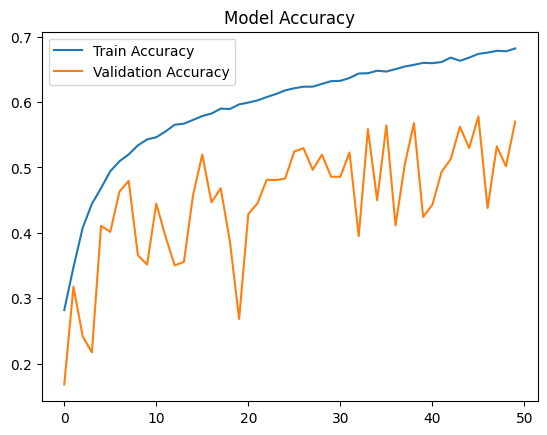

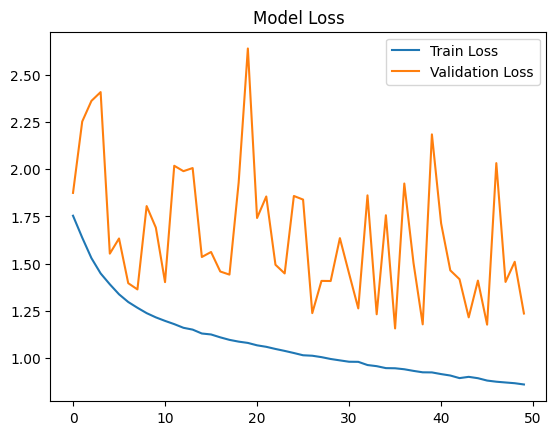

In [14]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


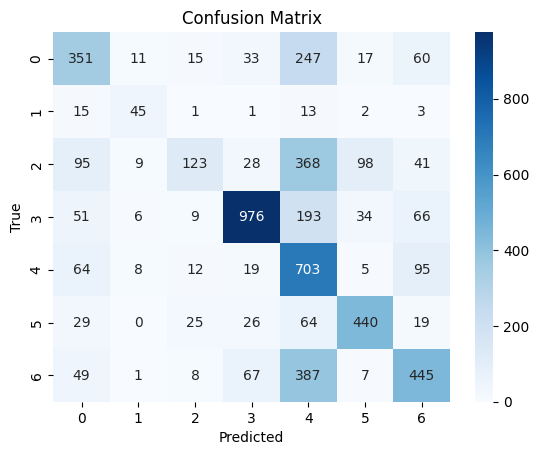

              precision    recall  f1-score   support

           0       0.54      0.48      0.51       734
           1       0.56      0.56      0.56        80
           2       0.64      0.16      0.26       762
           3       0.85      0.73      0.79      1335
           4       0.36      0.78      0.49       906
           5       0.73      0.73      0.73       603
           6       0.61      0.46      0.53       964

    accuracy                           0.57      5384
   macro avg       0.61      0.56      0.55      5384
weighted avg       0.63      0.57      0.57      5384



In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(7), yticklabels=range(7))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred_classes))


In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("emotion_detection_xception.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpzzuykjj9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  133970455996800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133970454828080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133970455283488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133970455288416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133970455290176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133970455287184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133970455288944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133970469512544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133970454837936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133970454833184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133970456847536: